In [1]:
from google.cloud import bigquery
import db_dtypes
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

client = bigquery.Client()
query = """
        SELECT * 
        FROM `oil-gas-analysis.quarterly_data.oil-gas-metrics` 
        WHERE quarter <= TIMESTAMP(CURRENT_DATE())
        ORDER BY quarter
        """
# load data
try:
    df = client.query(query).to_dataframe()
    print("Data loaded successfully!")
    print("\nColumns:", df.columns.tolist())
    print("Shape:", df.shape)
    # print("Head:", df.head)
except Exception as e:
    print(f'Error: {e}')


Data loaded successfully!

Columns: ['quarter', 'coil_tubing', 'directional_services', 'drilling_fluids', 'facilities', 'field_supervision', 'fuel', 'horizontal_well_stimulation', 'land_rig', 'octg', 'proppant', 'water', 'water_hauling', 'wireline_and_perforation', 'wti', 'rigs', 'spuds', 'fracs', 'total_lateral_length', 'stages']
Shape: (40, 20)


In [2]:
def calculate_efficiency_metrics(df):
    """
    Add efficiency metrics to dataset
    """
    df = df.copy()
    
    # drilling efficiencies
    df['spuds_per_rig'] = df['spuds'] / df['rigs']
    df['feet_per_rig'] = df['total_lateral_length'] / df['rigs']
    df['feet_per_spud'] = df['total_lateral_length'] / df['spuds']
    
    # completion efficiencies
    df['feet_per_frac'] = df['total_lateral_length'] / df['fracs']
    
    return df

In [3]:
# data validation

def verify_and_preprocess_data(df):
    
    """
    Load, calculate efficiencies, and preprocess data
    
    Parameters:
    -----------
    df : DataFrame with quarterly data
    """
        
    if df is None:
        return
    # first, normalize the timestamps to remove timezone information
    df['quarter'] = df['quarter'].dt.tz_localize(None)

    print('---Overview---')
    print(f'Time span: {df["quarter"].min()} to {df["quarter"].max()}')
    print(f'Number of quarters: {len(df)}')
    
    
    # check for missing values
    print('\n---Missing values---')
    missing = df.isnull().sum()
    if (missing.any()):
        print(f'Missing {missing} values.')
    else:
        print('No missing values found.')
    
    # display data types
    print('\n---Data Types---')
    print(df.dtypes)
    
    # display basic stats
    print('\n---Basic Statistics---')
    print(df.describe())
    
    # check for quarterly continuity

    # create expected quarterly time stamps
    start_date = df['quarter'].min()
    end_date = df["quarter"].max()

    # create custom quarter dates at midnight
    expected_quarters = []
    current = start_date

    while current <= end_date:
        if current.month in [1,4,7,10]:
            timestamp = pd.Timestamp(
                year=current.year,
                month=current.month,
                day=1,
                hour=0,
                minute=0,
                second=0
            )
            expected_quarters.append(timestamp)
        current = current + pd.DateOffset(months=1)
    expected_quarters = pd.DatetimeIndex(expected_quarters)

    # compare with dataset

    actual_quarters = set(df['quarter'])
    missing_quarters = set(expected_quarters) - actual_quarters
    extra_quarters = actual_quarters - set(expected_quarters)

    print("\n---Quarter validation---")
    print("Expected format:", pd.Timestamp(2024,1,1,0,0,0))
    print("\nActual timestamps:")
    for q in sorted(actual_quarters)[:5]:
        print(q)

    # check for missing quarters

    if missing_quarters:
        print("Missing quarters:")
        for q in sorted(missing_quarters):
            print(q)
    else:
        print("\nNo missing quarters.")

    # check for extra quarters

    if extra_quarters:
        print("Unexpected quarterly data:")
        for q in sorted(extra_quarters):
            print(q)
    else:
        print("No unexpected quarters.")

    # verify timestamp consistency

    print("\n---Timestamp format verification---")
    inconsistent = df[
        (df['quarter'].dt.day != 1) |
        (df['quarter'].dt.hour != 0) |
        (df['quarter'].dt.minute != 0) |
        (df['quarter'].dt.second != 0) |
        ~(df['quarter'].dt.month.isin([1,4,7,10]))
          ]

    if not inconsistent.empty:
          print("Found inconsistent timestamps")
          print(inconsistent["quarter"])
    else:
          print("Timestamps are consistent with expected format.")

    

In [4]:
verify_and_preprocess_data(df)

    

---Overview---
Time span: 2015-01-01 00:00:00 to 2024-10-01 00:00:00
Number of quarters: 40

---Missing values---
No missing values found.

---Data Types---
quarter                        datetime64[us]
coil_tubing                           float64
directional_services                  float64
drilling_fluids                       float64
facilities                            float64
field_supervision                     float64
fuel                                  float64
horizontal_well_stimulation           float64
land_rig                              float64
octg                                  float64
proppant                              float64
water                                 float64
water_hauling                         float64
wireline_and_perforation              float64
wti                                   float64
rigs                                  float64
spuds                                 float64
fracs                                 float64
total_lateral_l

In [5]:

# let's begin with a normalized time-series plot to visualize COVID impact and 
# potential lead/lag relationships between metrics

# initial visualizations 

def create_initial_plots(df):
    if df is None:
        return
    
    # time series plot of WTI and key metrics (core activity cascade in oil & gas operations)
    plt.figure(figsize=(15,8))
    
    # normalize data for comparison
    normalized_df = df[['wti', 'rigs', 'spuds', 'fracs']].apply(
        lambda x: (x - x.mean()) / x.std()
    )
    
    for col in normalized_df.columns:
        plt.plot(df['quarter'], normalized_df[col], label=col)
        
    plt.title('Normalized Time Series of Key Metrics')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    
    

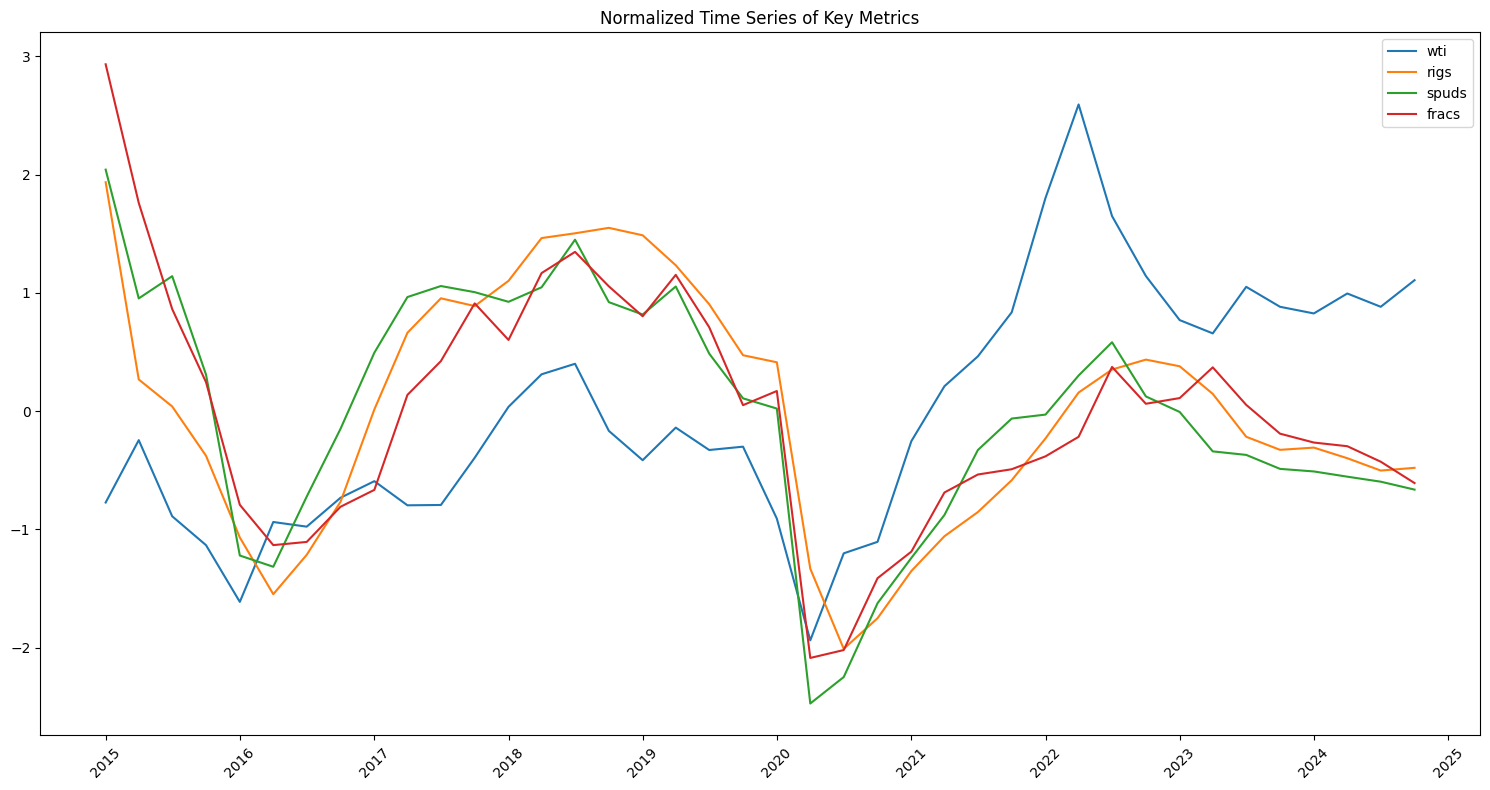

In [6]:
create_initial_plots(df)


# plot demonstrates core activity cascade in oil & gas operations
# WTI price = primary market driver
# Rigs = first operational response to price delta
# Spuds (wells started) = result of rig activity
# Fracs (completion operations) = final major step before production, represents investment commitment
#
# this selection helps to visualize:
# operational delays
# decision-making patterns
# industry response times
# investment cycle timing

# clear COVID impact is also evident, and will need to be addressed

In [7]:
# three-period analysis to account for COVID

# first, we perform sensitivity analysis to:
#     - validate/adjust period boundaries for each metric
#     - quantify the robustness of findings
#     - identify metrics particularly sensitive to period definition

# we do this prior to consideration of lead/lag relationships to:
# - provide for more direct interpretation of period boundaries
# - capture immediate covid impacts
# - avoid assumptions about lag structure
# - maintain independent observations for statistical rigor


METRIC_GROUPS = {
    'market_indicators': ['wti'],
    'activity_metrics': ['rigs', 'spuds', 'fracs', 'total_lateral_length', 'stages',
                        # add efficiency metrics
                        'spuds_per_rig', 'feet_per_rig', 'feet_per_spud', 'feet_per_frac'],
    'drilling_costs': ['land_rig', 'directional_services', 'drilling_fluids', 'octg'],
    'completion_costs': ['horizontal_well_stimulation', 'proppant', 'water', 'coil_tubing', 'wireline_and_perforation'],
    'other_costs': ['field_supervision', 'fuel', 'water_hauling', 'facilities']
}

derived_metrics = [
    'spuds_per_rig', 'feet_per_rig', 
    'feet_per_spud', 'feet_per_frac'
]

def analyze_covid_periods(
    df: pd.DataFrame, 
    metrics: List[str],
    base_covid_start: str = '2020-04-01', # COVID period initally defined as 4/1/2020 
    base_covid_end: str = '2021-12-31',   # to 12/31/2021
    window_sizes: List[int] = [1,2],      # quarters to shift
    test_statistic: str = 'ks'
) -> Dict:

    """
    analyze sensitivity of results to different COVID period definitions.
    
    parameters:
    -----------
    df : pandas DataFrame
        Time series data with metrics as columns
    base_covid_start : str
        Initial COVID period start date
    base_covid_end : str
        Initial COVID period end date
    window_sizes : list of int
        Number of quarters to shift boundaries for sensitivity testing
    test_statistic : str
        Statistical test to use: 'ks' for Kolmogorov-Smirnov or 't' for t-test
    
    returns:
    --------
    dict containing:
    - optimal_periods: Dict of optimal period boundaries for each metric
    - sensitivity_scores: DataFrame of sensitivity scores
    - statistical_tests: DataFrame of test results
    """
    
    results = {
        'optimal_periods': {},
        'sensitivity_scores': pd.DataFrame(),
        'statistical_tests': pd.DataFrame()
    }
    

    
    base_start = pd.to_datetime(base_covid_start).tz_localize('UTC')
    base_end = pd.to_datetime(base_covid_end).tz_localize('UTC')
    
    # ensure we're working with a datetime column
    
    df = df.copy()
    if 'quarter' in df.columns:
        df['date'] = pd.to_datetime(df['quarter'])
        if df['date'].dt.tz is None:
            df['date'] = df['date'].dt.tz_localize('UTC')
    else:
        df['date'] = df.index
        if df['date'].dt.tz is None:
            df['date'] = df['date'].dt.tz_localize('UTC')
    
    # generate potential period boundaries
    
    start_dates = [base_start - pd.DateOffset(months=3*w) for w in window_sizes]
    start_dates.extend([base_start + pd.DateOffset(months=3*w) for w in window_sizes])
    start_dates.append(base_start)
    
    end_dates = [base_end - pd.DateOffset(months=3*w) for w in window_sizes]
    end_dates.extend([base_end + pd.DateOffset(months=3*w) for w in window_sizes])
    end_dates.append(base_end)
    
    # analyze each metric
    
    for metric in metrics:
        # skip derived metrics
        if metric in derived_metrics:
            print(f'Skipping derived metric {metric}...')
            continue
        print(f'\nAnalyzing {metric}...')
        sensitivity_scores = []
        test_results = []
        
        # base period statistics
        base_mask = (df['date'] >= base_start) & (df['date'] <= base_end)
        base_covid = df.loc[base_mask, metric]
        base_non_covid = df.loc[~base_mask, metric]
        
        if len(base_covid) == 0 or len(base_non_covid) == 0:
            print(f"Warning: No data found for {metric} in base period")
            continue
        
        if test_statistic == 'ks':
            base_stat, base_pval = stats.ks_2samp(base_covid, base_non_covid)
        else: # t-test
            base_stat, base_pval = stats.ttest_ind(base_covid, base_non_covid)
        
        for start in start_dates:
            for end in end_dates:
                if start >= end:
                    continue
                
                mask = (df['date'] >= start) & (df['date'] <= end)
                covid_period = df.loc[mask, metric]
                non_covid = df.loc[~mask, metric]
                
                # check for empty periods
                
                if len(covid_period) == 0 or len(non_covid) == 0:
                    continue
                
                if test_statistic == 'ks':
                    stat, pval = stats.ks_2samp(covid_period, non_covid)
                else: # t-test
                    stat, pval = stats.ttest_ind(covid_period, non_covid)
                    
                # calculate sensitivity score
                sensitivity = abs((stat - base_stat) / base_stat)
                
                sensitivity_scores.append({
                    'metric': metric,
                    'start_date': start.tz_localize(None),
                    'end_date': end.tz_localize(None),
                    'sensitivity': sensitivity,
                    'p_value': pval
                })
                
                test_results.append({
                    'metric': metric,
                    'start_date': start.tz_localize(None),
                    'end_date': end.tz_localize(None),
                    'test_statistic': stat,
                    'p_value': pval
                })
                
                # find optimal periods (strongest statistical difference)
                if sensitivity_scores:
                    sensitivity_df = pd.DataFrame(sensitivity_scores)
                    test_df = pd.DataFrame(test_results)
                
                optimal_idx = test_df['test_statistic'].abs().idxmax()
                results['optimal_periods'][metric] = {
                    'start': test_df.loc[optimal_idx, 'start_date'],
                    'end': test_df.loc[optimal_idx, 'end_date']
                }
                
                # check for empty dataframes before concat
                
                if results['sensitivity_scores'].empty:
                    results['sensitivity_scores'] = sensitivity_df
                else:
                    results['sensitivity_scores'] = pd.concat([results['sensitivity_scores'], sensitivity_df])
                    
                if results['statistical_tests'].empty:
                    results['statistical_tests']= test_df
                else:
                    results['statistical_tests'] = pd.concat([results['statistical_tests'], test_df])
                
    return results
        
def visualize_period_sensitivity(results: Dict, metric: str) -> None:
    """
    Create visualizations for period sensitivity analysis results
    
    Parameters:
    -----------
    results : Dict
        Analysis results dictionary
    metric : str
        Metric to visualize
    """
    
    # get optimal period for this metric
    
    optimal_start = results['optimal_periods'][metric]['start']
    optimal_end = results['optimal_periods'][metric]['end']
    
    
    sensitivity_df = results['sensitivity_scores'][
        results['sensitivity_scores']['metric'] == metric
    ].copy()
    
    # convert dates to quarters for better visualization
    sensitivity_df['start_quarter'] = pd.PeriodIndex(sensitivity_df['start_date'], freq='Q')
    sensitivity_df['end_quarter'] = pd.PeriodIndex(sensitivity_df['end_date'], freq='Q')
        
    # handle duplicates before pivot by taking the mean sensitivity for each quarter combination
    sensitivity_matrix = (sensitivity_df
                          .groupby(['start_quarter', 'end_quarter'])['sensitivity']
                          .mean()
                          .reset_index()
                         )

    # create heatmap data
    pivot_data = sensitivity_matrix.pivot(
        index='start_quarter',
        columns='end_quarter',
        values='sensitivity'
    )
                          
    # ensure quarters are in chronological order
    pivot_data = pivot_data.sort_index(ascending=True)
    pivot_data = pivot_data.sort_index(axis=1, ascending=True)
                          
    # plot with seaborn
    
    sns.heatmap(
        pivot_data,
        cmap='YlOrRd',
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Sensitivity Score'}
    )
    plt.title(f'Period Sensitivity Analysis - {metric}\nOptimal Period: {optimal_start.strftime("%Y-%m-%d")} to {optimal_end.strftime("%Y-%m-%d")}')
    plt.xlabel('End Quarter')
    plt.ylabel('Start Quarter')
    
def run_covid_sensitivity_analysis(
    df: pd.DataFrame, 
    base_covid_start: str = '2020-04-01', # COVID period initally defined as 4/1/2020 
    base_covid_end: str = '2021-12-31',   # to 12/31/2021
    window_sizes: List[int] = [1,2],      # quarters to shift
) -> Dict:
    
    # run comprehensive analysis on all metric groups.
    
    results = {}
    
    for group_name, metrics in METRIC_GROUPS.items():
        print(f"\nAnalyzing {group_name}...")
        
        group_results = analyze_covid_periods(
            df=df,
            metrics=metrics,
            base_covid_start=base_covid_start,
            base_covid_end=base_covid_end,
            window_sizes=window_sizes
        )
        
        results[group_name] = group_results
        
        # print summary findings for group
        
        print("Optimal periods found:")
        for metric, periods in group_results['optimal_periods'].items():
            print(f"{metric}: {periods['start'].strftime('%Y-%m-%d')} to {periods['end'].strftime('%Y-%m-%d')}")
        
        # print avg sensitivity for group
        
        avg_sensitivity = group_results['sensitivity_scores']['sensitivity'].mean()
        print(f"Average group sensitivity: {avg_sensitivity:.3f}")
                  
    return results
                  
def generate_summary_visualizations(results: Dict, output_dir: str = None):
    
    # generate comprehensive visualizations of sensitivity analysis results
    #
    # create overview plot for all groups
    plt.figure(figsize=(15,10))
    
    group_sensitivities = []
    for group_name, group_results in results.items():
        # calculate avg sensitivity for each metric in group
        for metric in METRIC_GROUPS[group_name]:
            # skip derived metrics
            if metric in derived_metrics:
                continue
            metric_sensitivity = group_results['sensitivity_scores'][
                group_results['sensitivity_scores']['metric'] == metric]['sensitivity'].mean()
            
            group_sensitivities.append({
                'group': group_name,
                'metric': metric,
                'avg_sensitivity': metric_sensitivity
            })
    if group_sensitivities:            
        # create overview heatmap
        sensitivity_df = pd.DataFrame(group_sensitivities)
        pivot_data = sensitivity_df.pivot(
            index='group',
            columns='metric',
            values='avg_sensitivity'
        )

        plt.subplot(1,1,1)
        sns.heatmap(
            pivot_data,
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Average Sensitivity'}
        )
        plt.title('COVID Period Sensitivity by Metric and Group')
        plt.tight_layout()

        if output_dir:
            plt.savefig(f"{output_dir}/overall_sensitivity.png", bbox_inches='tight')
            plt.close()
        else:
            plt.show()
        
    # generate detailed plots for each group
    for group_name, group_results in results.items():
        metrics = [m for m in METRIC_GROUPS[group_name] if m not in derived_metrics]
        
        if not metrics: # skip if no metric to plot
            continue
        
        # create group subplot figure
        n_metrics = len(metrics)
        fig_rows = (n_metrics + 1) //2 # two plots per row
        plt.figure(figsize=(15,5 * fig_rows))
        
        for idx, metric in enumerate(metrics, 1):
            plt.subplot(fig_rows, 2, idx) 
            visualize_period_sensitivity(group_results, metric)

            
        plt.tight_layout()
        
        if output_dir:
            plt.savefig(f"{output_dir}/{group_name}_detailed.png", bbox_inches='tight')
            plt.close()
        else:
            plt.show()
            
def run_sensitivity_analysis(df: pd.DataFrame, output_dir: str = None):
    
    # convenience function to run complete analysis
    
    print("Starting COVID period sensitivity analysis...")
    results = run_covid_sensitivity_analysis(df)
    print("\nGenerating visualizations...")
    generate_summary_visualizations(results, output_dir)
    
    return results
    
    
    


Starting COVID period sensitivity analysis...

Analyzing market_indicators...

Analyzing wti...
Optimal periods found:
wti: 2020-01-01 to 2021-06-30
Average group sensitivity: 0.224

Analyzing activity_metrics...

Analyzing rigs...

Analyzing spuds...

Analyzing fracs...

Analyzing total_lateral_length...

Analyzing stages...
Skipping derived metric spuds_per_rig...
Skipping derived metric feet_per_rig...
Skipping derived metric feet_per_spud...
Skipping derived metric feet_per_frac...
Optimal periods found:
rigs: 2020-04-01 to 2021-06-30
spuds: 2020-04-01 to 2021-06-30
fracs: 2020-04-01 to 2021-06-30
total_lateral_length: 2020-04-01 to 2021-06-30
stages: 2020-04-01 to 2021-12-31
Average group sensitivity: 0.182

Analyzing drilling_costs...

Analyzing land_rig...

Analyzing directional_services...

Analyzing drilling_fluids...

Analyzing octg...
Optimal periods found:
land_rig: 2020-04-01 to 2021-06-30
directional_services: 2020-04-01 to 2021-06-30
drilling_fluids: 2020-10-01 to 2022-0

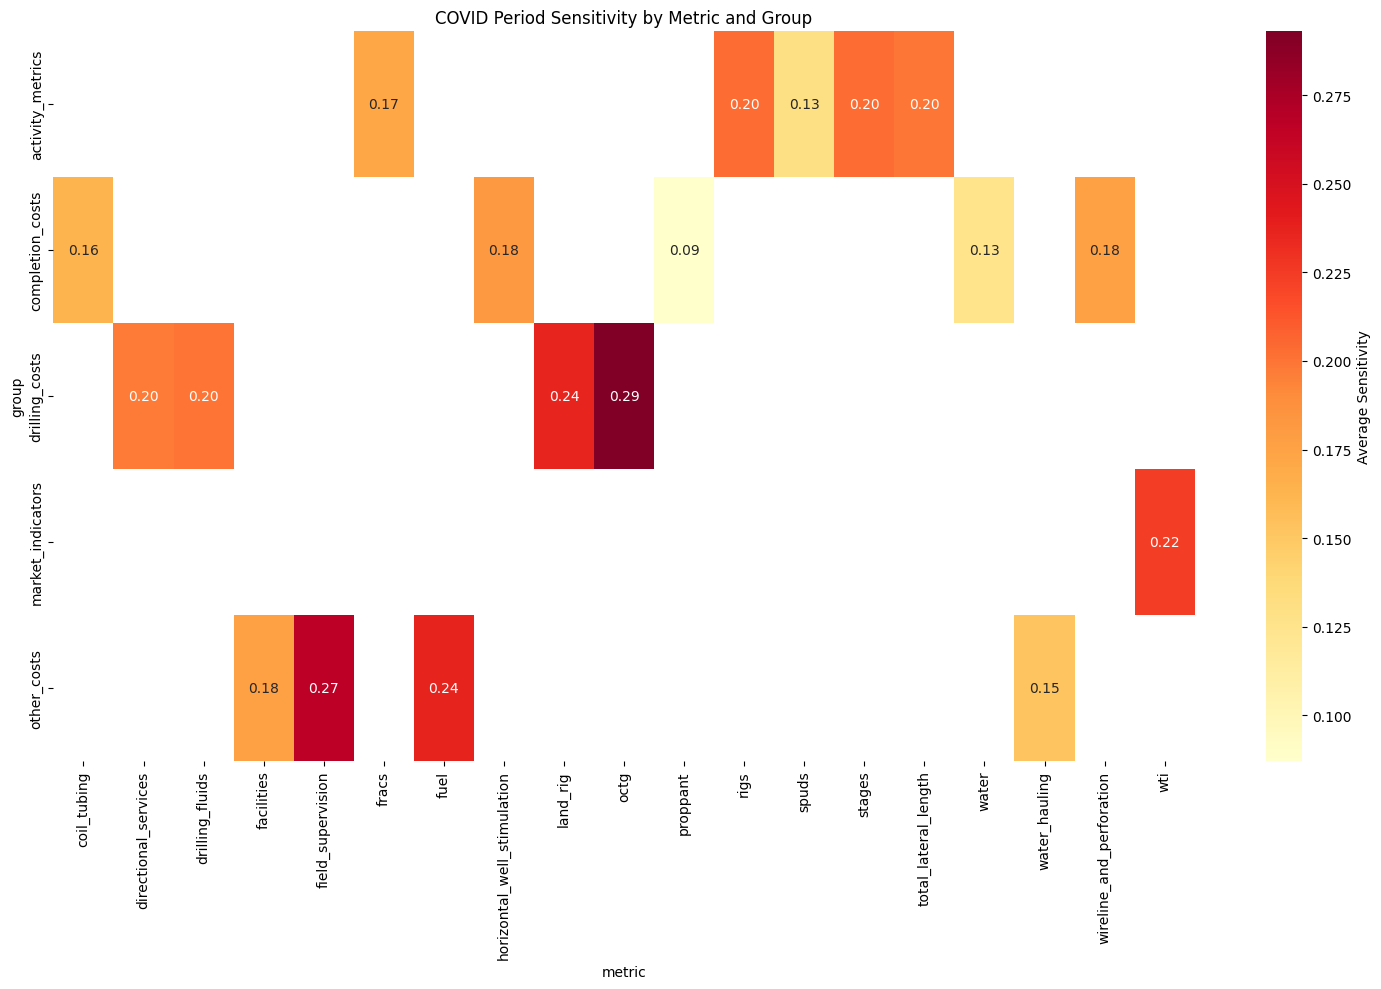

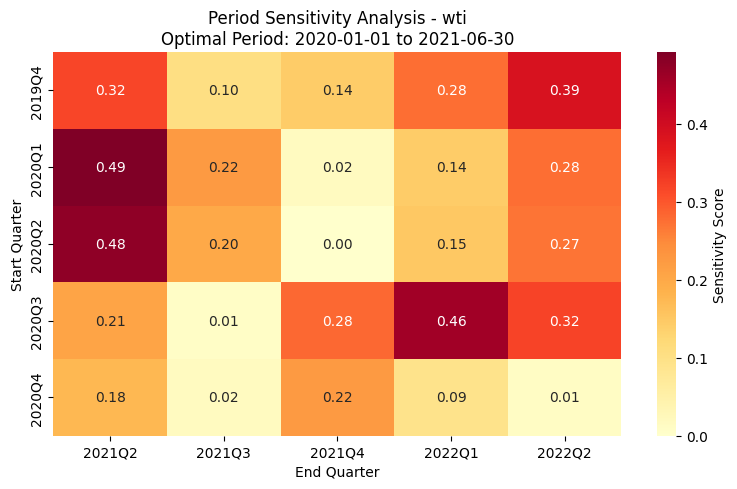

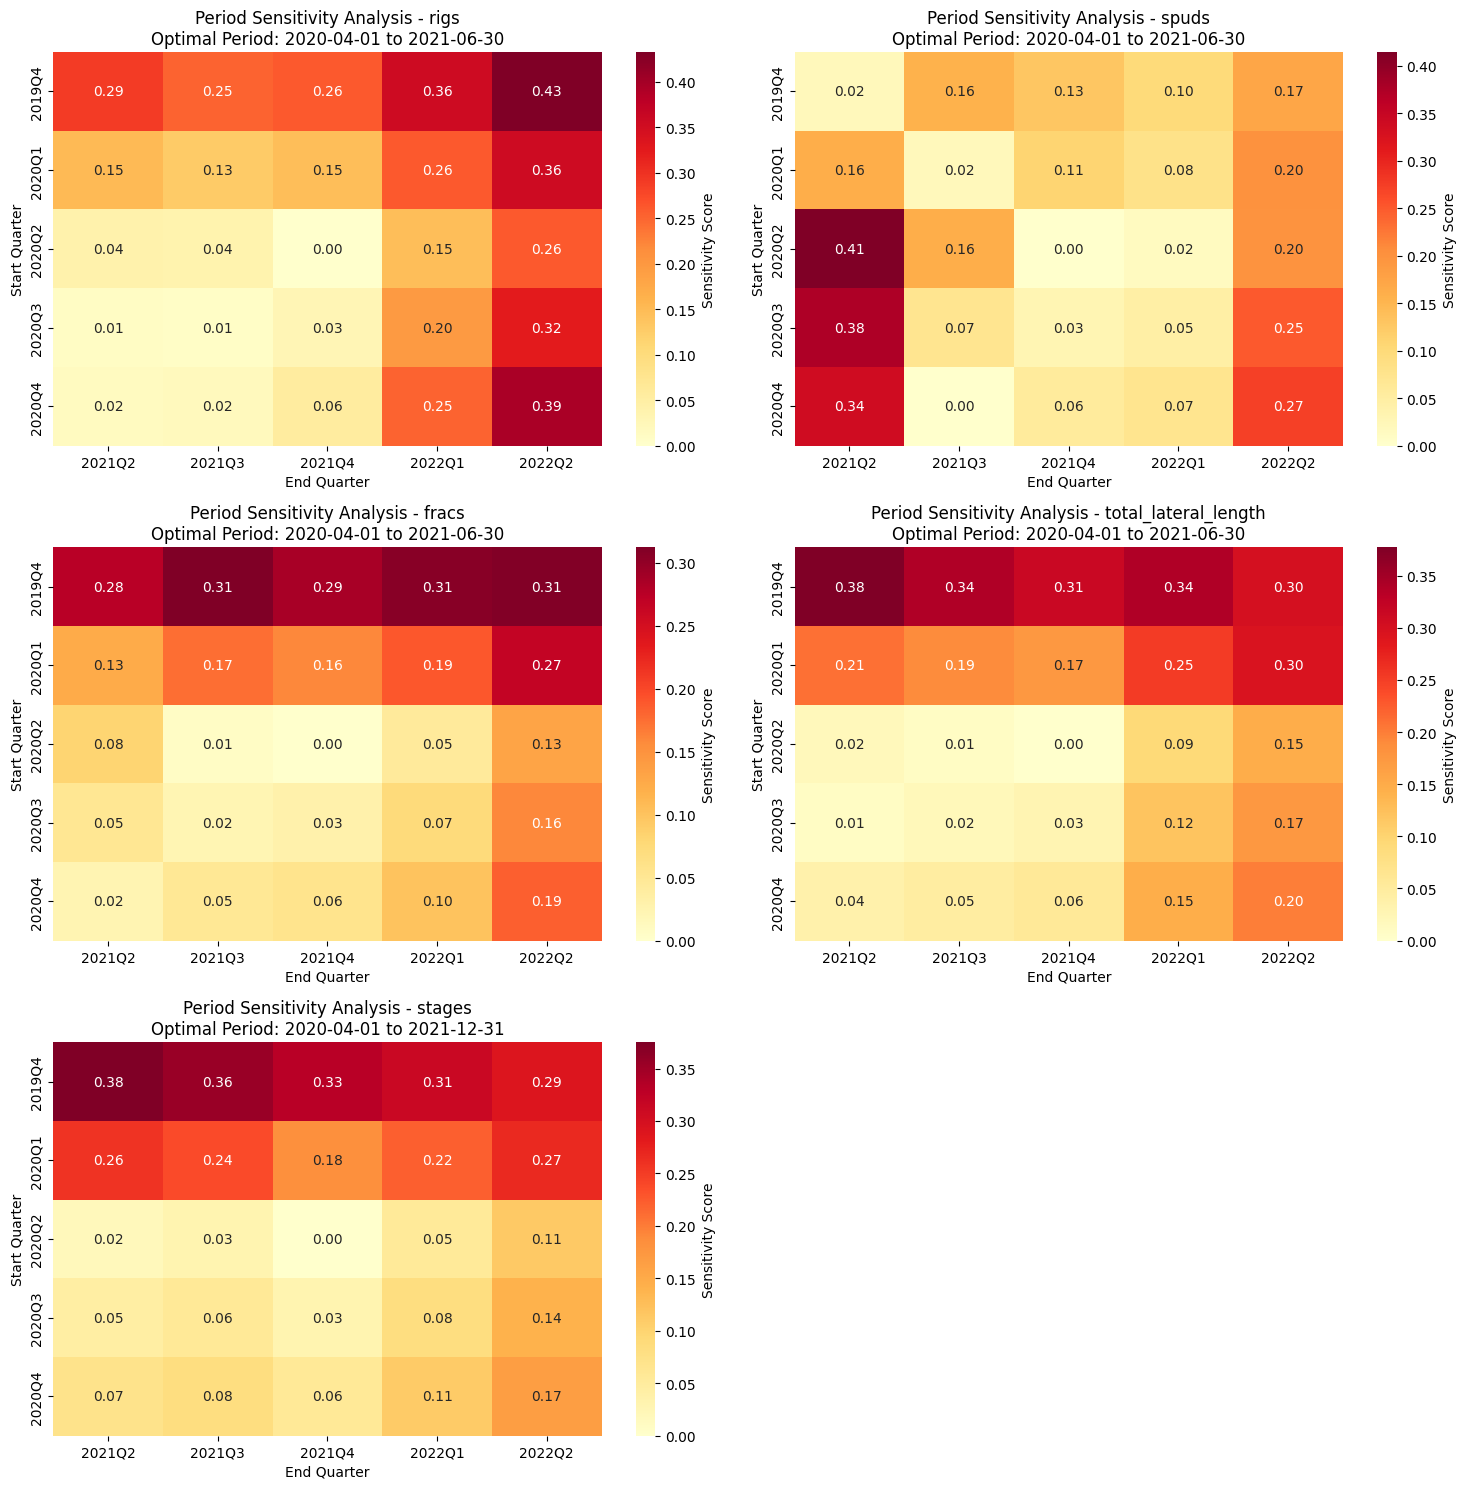

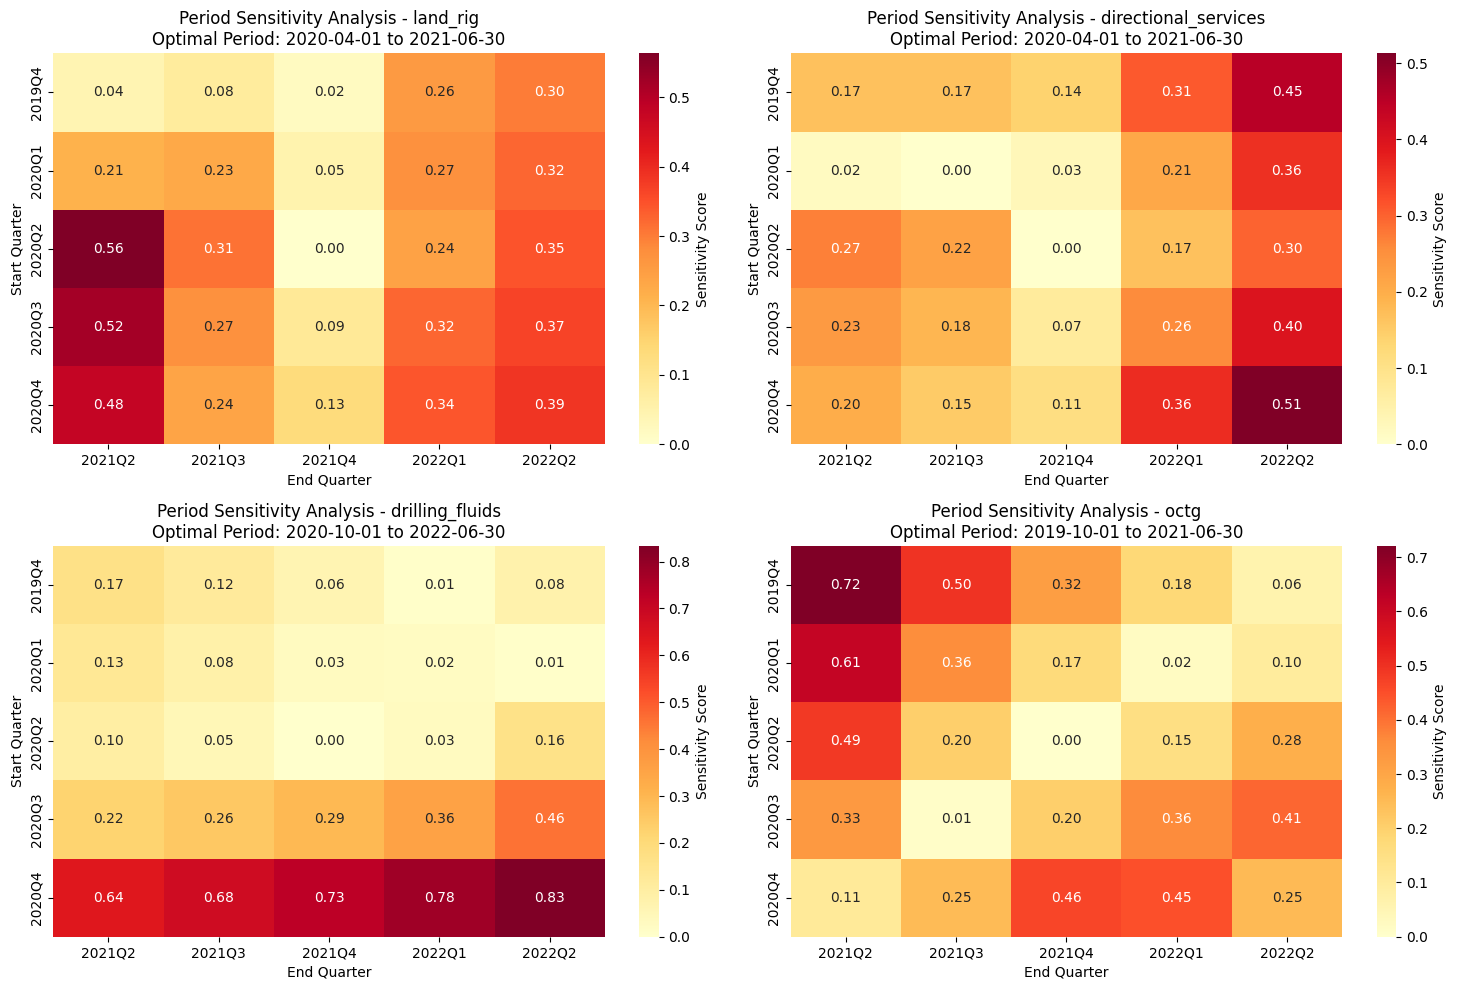

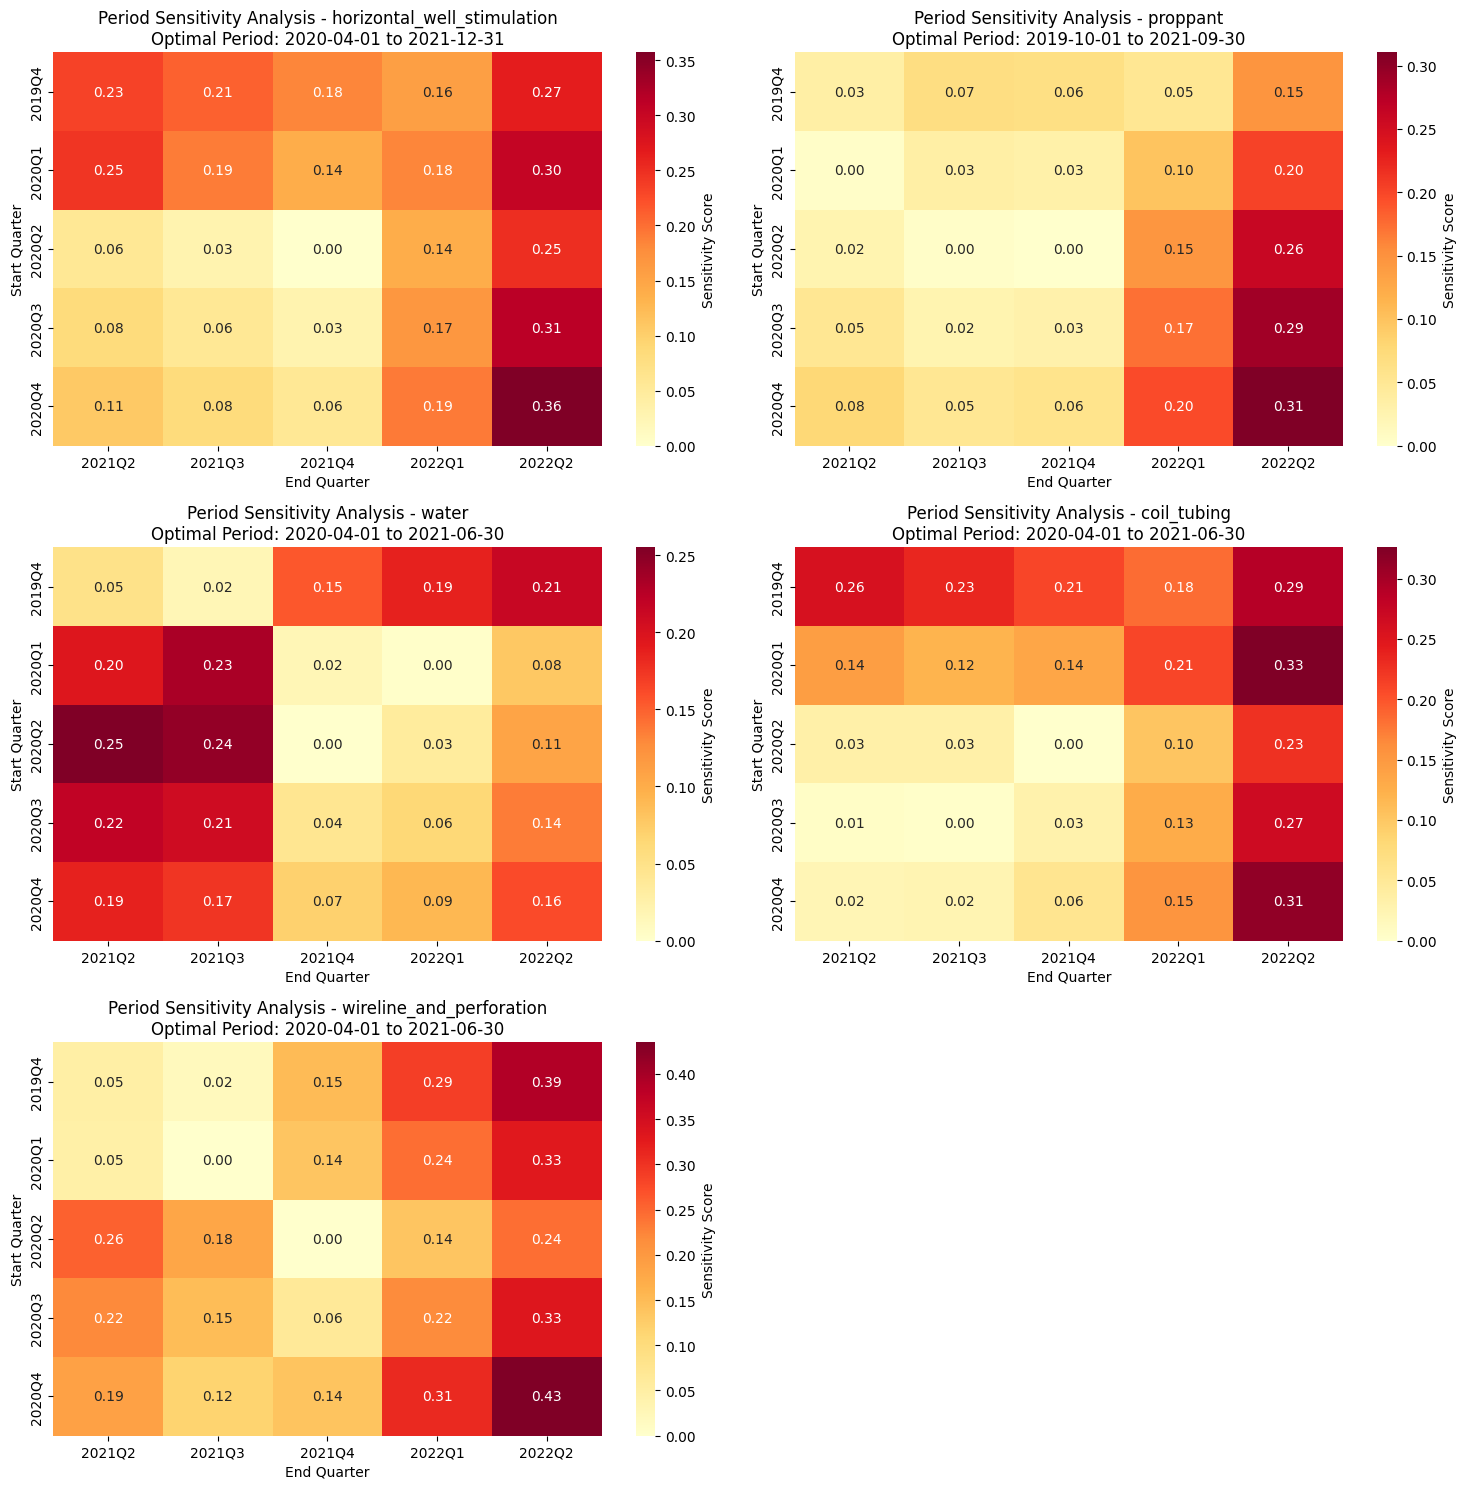

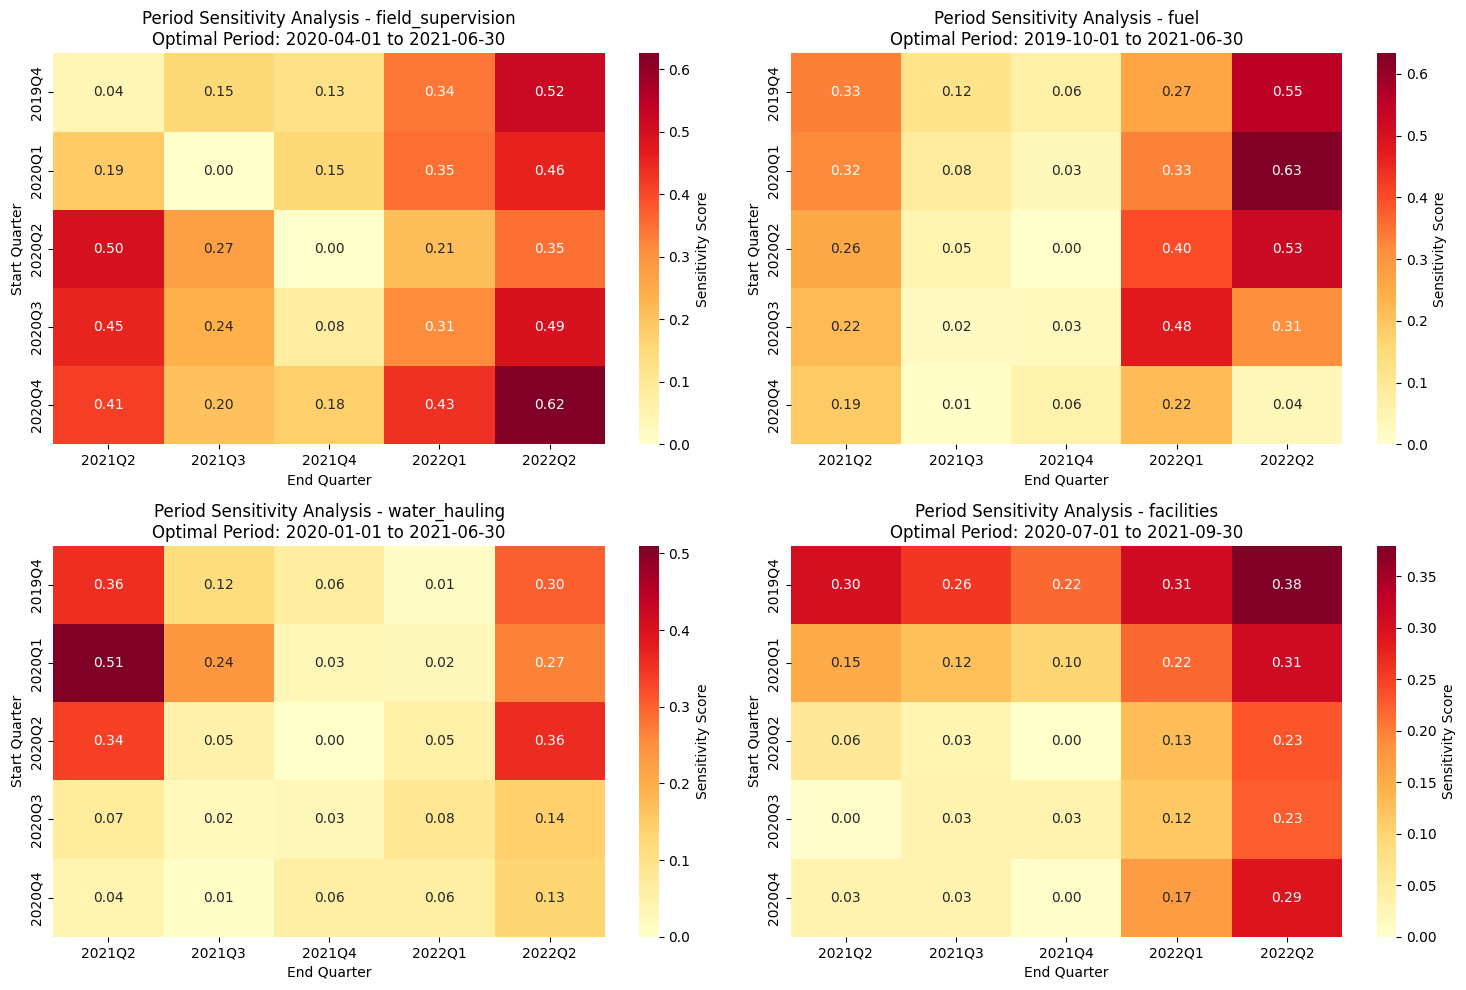

In [8]:
results = run_sensitivity_analysis(df)

In [9]:


# we will exclude the modal COVID period of 2020-04-01 to 2021-06-30 
# to exclude outliers and proceed with analysis of normal operations

def get_period_mask(
    df: pd.DataFrame,
    exclude_periods: Optional[List[Tuple[str, str]]] = None,
    include_periods: Optional[List[Tuple[str, str]]] = None
) -> pd.Series:
    """
    create a boolean mask for period selection.
    
    parameters:
    -----------
    df : DataFrame with 'quarter' column
    exclude_periods : List of (start, end) date tuples to exclude
    include_periods : List of (start, end) date tuples to specifically include
    
    returns:
    --------
    pd.Series: Boolean mask for period selection
    """
    
    mask = pd.Series(True, index=df.index)
    
    if include_periods:
        include_mask = pd.Series(False, index=df.index)
        for start, end in include_periods:
            include_mask |= ((df['quarter'] >= start) &
                             (df['quarter'] <= end))
            mask &= include_mask
            
    if exclude_periods:
        for start, end in exclude_periods:
            mask &= ~((df['quarter'] >= start) &
                      (df['quarter'] <= end))
            
    return mask

In [10]:

# with normal operations defined, determine correlations prior to 
# consideration of lead/lag relationships in the data

def correlation_analysis(df: pd.DataFrame, 
                         comparison_periods: Optional[Dict] = None
                        ) -> Dict:
    """
    analyze correlations with flexible period comparison.
    parameters:
    -----------
    df : DataFrame with time series data
    comparison_periods : Dict of period definitions, e.g.,
        {
            'exclude': ('2020-04-01', '2021-06-30'),  # periods to exclude
            'compare': [('2015-01-01', '2020-03-31'), 
                       ('2021-07-01', '2024-12-31')]  # periods to compare
        }
        If None, performs default COVID analysis
    """
    if df is None:
        return
    
    # define modal COVID period dates
    covid_start = '2020-04-01'
    covid_end = '2021-06-30'
    
    # define variable groups
    
    market_indicators = ['wti']
    activity_metrics = ['rigs', 'spuds', 'fracs', 'total_lateral_length', 'stages']
    drilling_costs = ['land_rig', 'directional_services', 'drilling_fluids', 'octg']
    completion_costs = ['horizontal_well_stimulation', 'proppant', 'water', 'coil_tubing', 'wireline_and_perforation']
    other_costs = ['field_supervision', 'fuel', 'water_hauling', 'facilities']
    
    # handle period selection
    if comparison_periods:
        if 'exclude' in comparison_periods:
            mask = get_period_mask(df, exclude_periods=[comparison_periods['exclude']])
            df_no_covid = df[mask]
        elif 'compare' in comparison_periods:
            period_dfs = []
            for period in comparison_periods['compare']:
                mask = get_period_mask(df, include_periods=[comparison_periods['compare'][0]])
                df_no_covid = df[mask]
            periods = {'period1': period_dfs[0], 'period2': period_dfs[1]}
    else:
    # create non-COVID mask
    
        covid_mask = ~((df['quarter'] >= covid_start) & (df['quarter'] <= covid_end))
        df_no_covid = df[~((df['quarter'] >= '2020-04-01') &
                           (df['quarter'] <= '2021-06-30'))]
    
    def print_correlations(data, title):
        print(f"\n---{title}---")
    
        results = {}
                            
        # activity metrics vs WTI

        print("\nActivity Metrics vs. WTI Correlation:")
        activity_corr = data[["wti"] + activity_metrics].corr()['wti']
        print(activity_corr)
        results['activity'] = activity_corr
                            

        # drilling metrics vs WTI

        print("\nDrilling Metrics vs. WTI Correlation:")
        drilling_corr = data[["wti"] + drilling_costs].corr()['wti']
        print(drilling_corr)
        results['drilling'] = drilling_corr

        # completion metrics vs WTI

        print("\nCompletion Metrics vs. WTI Correlation:")
        completion_corr = data[["wti"] + completion_costs].corr()['wti']
        print(completion_corr)
        results['completion'] = completion_corr
        
        # other metrics vs WTI

        print("\nOther Metrics vs. WTI Correlation:")
        other_corr = data[["wti"] + other_costs].corr()['wti']
        print(other_corr)
        results['other'] = other_corr
    
        return results
    
    full_period_corr = print_correlations(df, "Correlation Analysis - Full Timeline")
    filtered_period_corr = print_correlations(df_no_covid, "Correlation Analysis - Filtered Period")
    
    print("\n---Correlation Differences (Filtered minus Full Period)---")
    differences = {}
    
    for category in ['activity', 'drilling', 'completion', 'other']:
        diff = filtered_period_corr[category] - full_period_corr[category]
        differences[category] = diff
        

        print(f"\n{category.title()} Metrics Correlation Difference:")
        print(diff)
        
        # highlight significant changes
        significant_changes = diff[abs(diff) > 0.1] # threshold of 0.1
        if not significant_changes.empty:
            print(f"\nSignificant Changes in {category} correlations:")
            print(significant_changes)
            print("Threshold: 0.1")

    # return results for viz
    
    return {
        'full_period': full_period_corr,
        'filtered_period': filtered_period_corr,
        'differences': differences,
        'groups': {
            'market': market_indicators,
            'activity': activity_metrics,
            'drilling': drilling_costs,
            'completion': completion_costs,
            'other': other_costs
        }
    }
        
def visualize_correlation_comparison(results: Dict):
    # setup metrics dict for organized plotting
    metrics = {
        'Activity': results['groups']['activity'],
        'Drilling': results['groups']['drilling'],
        'Completion': results['groups']['completion'],
        'Other': results['groups']['other']
    }
    
    n_groups = len(metrics)
    
    # create one large figure with subplots
    fig, axes = plt.subplots(n_groups, 1, figsize=(12, 4*n_groups))
          
    # safety check for axes
    if n_groups == 1:
          axes = [axes] # make it iterable
    
    for i, ((name, metric_list), ax) in enumerate(zip(metrics.items(), axes)):
        # debug print
        print(f'\nProcessing {name}...')
        
        # get correlations for both periods
        full_corr = [results['full_period'][name.lower()][m] for m in metric_list]
        filtered_corr = [results['filtered_period'][name.lower()][m] for m in metric_list]
        
        # create bar positions
        x = np.arange(len(metric_list))
        width = 0.35

        # create bars on current subplot
        ax.bar(x-width/2, full_corr, width, label='Full Period')
        ax.bar(x+width/2, filtered_corr, width, label='Filtered Period')

        # customize current subplot
        ax.set_ylabel('Correlation with WTI')
        ax.set_title(f'{name} Metrics - Correlation Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(metric_list, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # add correlation difference annotations
        for j, (full, filtered) in enumerate(zip(full_corr, filtered_corr)):
            diff = filtered - full

            # highlight significant differences
            if abs(diff) > 0.1:
                ax.annotate(f'Δ={diff:.2f}',
                            xy=(j, max(full, filtered)),
                            xytext=(0,10),
                            textcoords='offset points',
                            ha='center',
                            va='bottom',
                            color='red' if diff < 0 else 'green')
    plt.tight_layout()
    plt.show()


---Correlation Analysis - Full Timeline---

Activity Metrics vs. WTI Correlation:
wti                     1.000000
rigs                    0.175151
spuds                   0.163984
fracs                   0.136649
total_lateral_length    0.613818
stages                  0.627843
Name: wti, dtype: float64

Drilling Metrics vs. WTI Correlation:
wti                     1.000000
land_rig                0.774698
directional_services    0.823151
drilling_fluids         0.868881
octg                    0.813434
Name: wti, dtype: float64

Completion Metrics vs. WTI Correlation:
wti                            1.000000
horizontal_well_stimulation    0.650115
proppant                       0.160072
water                          0.660974
coil_tubing                    0.571704
wireline_and_perforation       0.715748
Name: wti, dtype: float64

Other Metrics vs. WTI Correlation:
wti                  1.000000
field_supervision    0.831681
fuel                 0.946707
water_hauling        0.866126


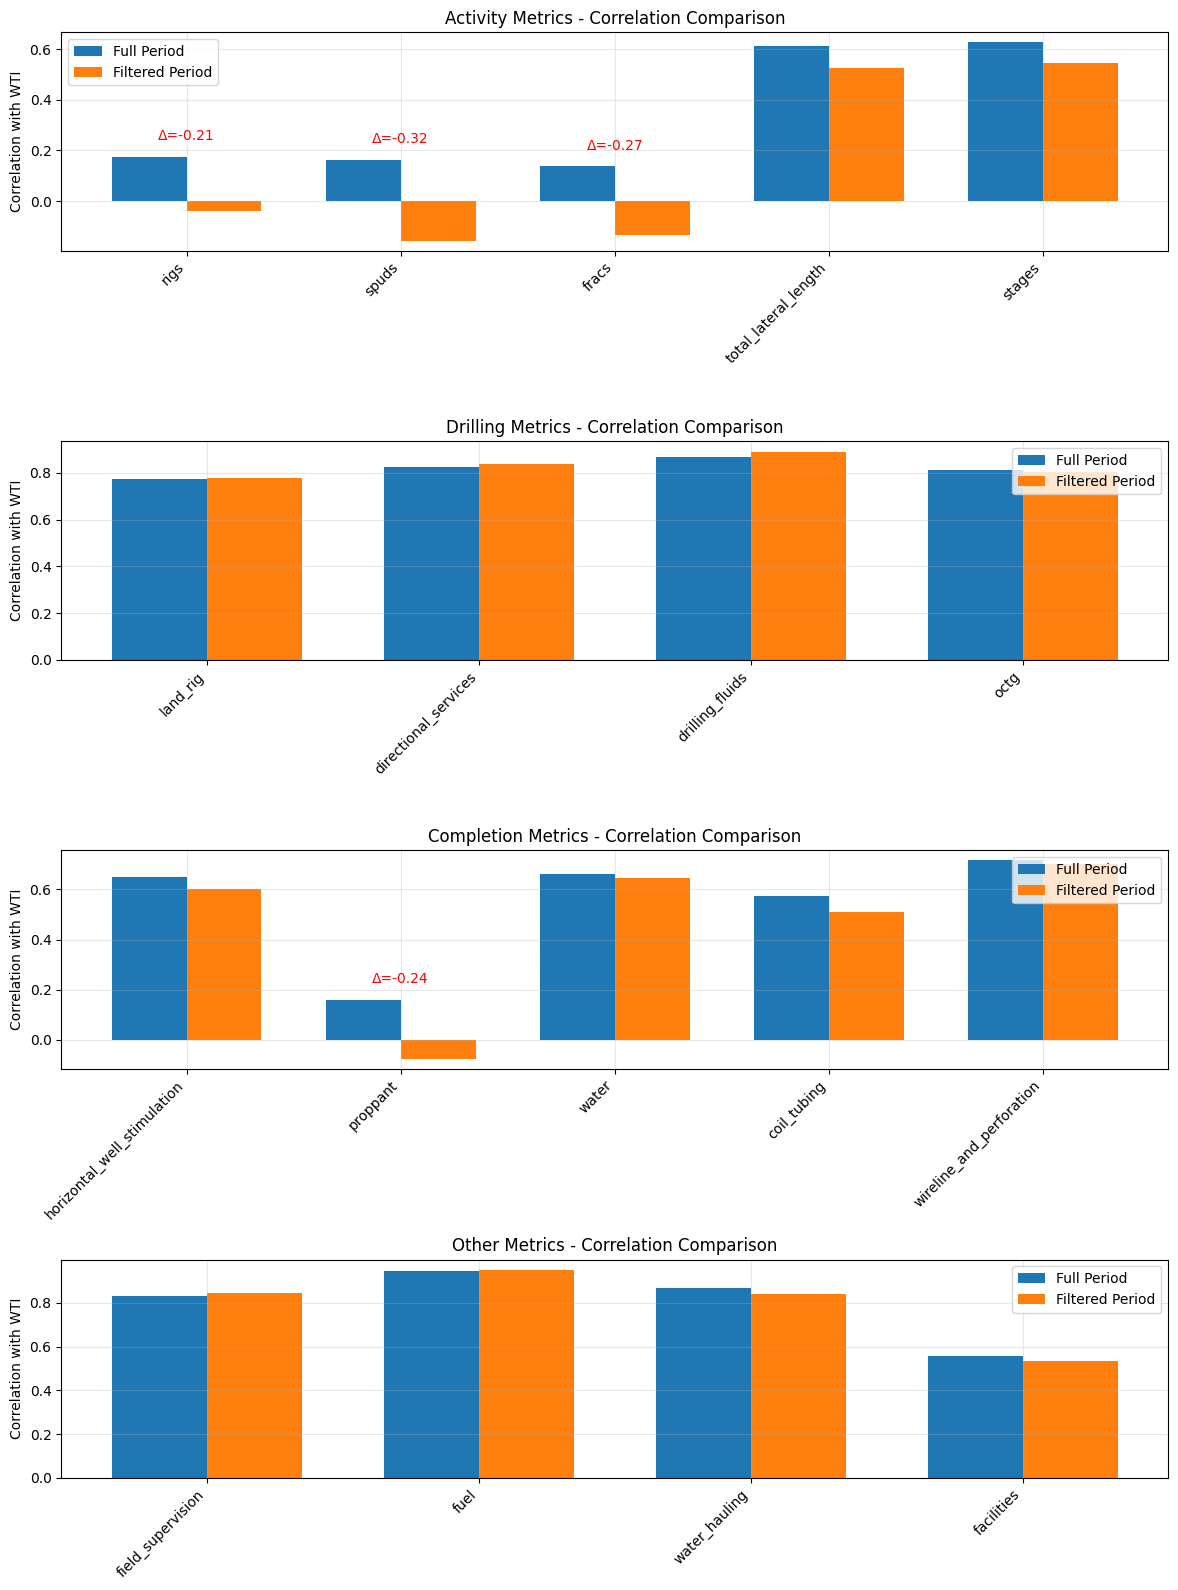

In [11]:

# run correlation analysis WITHOUT lags
visualize_correlation_comparison(correlation_analysis(df))

In [12]:

# the sensitivity and correlation analysis suggests:
# COVID impact wasn't uniform across industry
# there is a clear sequence of impact and recovery
# some services show more pricing stability than others
# June 2021 is a key recovery milestone 

# let's analyze potential lead/lag relationships and compare to a priori 
# industry expectations / operational realities

# define metric groups by phase and include efficiency metrics to evaluate
# whether detrending is warranted

METRIC_GROUPS = {
    'market_indicators': ['wti'],
    'activity_metrics': ['rigs', 'spuds', 'fracs', 'total_lateral_length', 'stages',
                        # add efficiency metrics
                        'spuds_per_rig', 'feet_per_rig', 'feet_per_spud', 'feet_per_frac'],
    'drilling_costs': ['land_rig', 'directional_services', 'drilling_fluids', 'octg'],
    'completion_costs': ['horizontal_well_stimulation', 'proppant', 'water', 'coil_tubing', 'wireline_and_perforation'],
    'other_costs': ['field_supervision', 'fuel', 'water_hauling', 'facilities']
}

In [31]:
def prepare_timing_analysis(
    df: pd.DataFrame,
    max_lag: int = 4,
    ma_window: int = 2,
    metrics: Dict[str, List[str]] = METRIC_GROUPS
) -> Dict:
    """
    prepare timing analysis by calculating moving averages and analyzing 
    lead/lag relationships
    """
    
    
    METRIC_GROUPS = {
    'market_indicators': ['wti'],
    'activity_metrics': ['rigs', 'spuds', 'fracs', 'total_lateral_length', 'stages'],
    'drilling_costs': ['land_rig', 'directional_services', 'drilling_fluids', 'octg'],
    'completion_costs': ['horizontal_well_stimulation', 'proppant', 'water', 'coil_tubing', 'wireline_and_perforation'],
    'other_costs': ['field_supervision', 'fuel', 'water_hauling', 'facilities']
    }
    
    analysis_df = df.copy()
    
    ma_data = pd.DataFrame(index=analysis_df.index)
    ma_data['quarter'] = analysis_df['quarter']
    
    # add raw activity metrics first
    activity_metrics = ['rigs', 'spuds', 'fracs', 'total_lateral_length', 'stages']

    for metric in activity_metrics:
        ma_data[metric] = analysis_df[metric]

        
    # add raw wti
    ma_data['wti'] = analysis_df['wti']
    
    # calculate MA for WTI
    ma_data['wti_ma'] = analysis_df['wti'].rolling(window=ma_window, min_periods=1).mean()
    
    #calculate MA for all other metrics
    for group_name, group_metrics in metrics.items():
        for metric in group_metrics:
            if metric != 'wti':
                if metric not in derived_metrics:
                    ma_data[f'{metric}_ma'] = analysis_df[metric].rolling(
                        window=ma_window, min_periods=1).mean()
                    
    print("Moving average columns created:", [col for col in ma_data.columns if col.endswith('_ma')])
    print('\nColumns with both raw and MA:', [col for col in ma_data.columns])
    print("\nHead of MA data:")
    print(ma_data.head())     
    
    return ma_data

In [14]:
def calculate_lag_correlations(
    ma_data: pd.DataFrame, 
    target_col: str = 'wti_ma', 
    max_lag: int = 4
):
    """
    calculate correlations between target column and other metrics at different lags
    """
    lag_correlations = {}
    
    # get metric column list (excluding quarter and target)
    metric_cols = [col for col in ma_data.columns
                   if col.endswith('_ma') and col != target_col]
    
    for lag in range(max_lag + 1):
        lag_correlations[lag] = {}
        
        for metric in metric_cols:
            # shift data and align for correlation
            if lag < 0:
                # metric leads WTI
                aligned_target = ma_data[target_col].iloc[-lag:] # start later in WTI
                aligned_metric = ma_data[metric].iloc[:lag] # end earlier in metric
            else:
                # metric lags WTI
                aligned_target = ma_data[target_col].iloc[:-lag] if lag > 0 else ma_data[target_col]
                aligned_metric = ma_data[metric].iloc[lag:] if lag > 0 else ma_data[metric]
                
            # calculate correlation
            correlation = aligned_target.corr(aligned_metric)
            lag_correlations[lag][metric] = correlation
            
    lag_df = pd.DataFrame(lag_correlations)
                          
    # find optimal lag for each metric
    optimal_lags = {}
    for metric in metric_cols:
        # get absolute correlations for metric across all lags
        abs_corrs = lag_df.loc[metric].abs()
        # find lag with highest absolute correlation
        optimal_lag = abs_corrs.idxmax()
        optimal_lags[metric] = {
            'lag': optimal_lag,
            'correlation': lag_df.loc[metric, optimal_lag]
        }
    return {
        'lag_correlations': lag_df,
        'optimal_lags': optimal_lags
    }
            

In [15]:
def analyze_efficiency_trends(df: pd.DataFrame):
    """
    Analyze efficiency metrics independently of WTI response
    """
    
    # create copy
    analysis_df = df.copy()
    
    # add efficiency columns
    analysis_df = calculate_efficiency_metrics(analysis_df)
    
    efficiency_metrics = [
        'spuds_per_rig', 'feet_per_rig',
        'feet_per_spud', 'feet_per_frac'
    ]
    
    # create linear index
    numeric_index = pd.Series(range(len(analysis_df)))
    
    # calculate trend statistics
    trends = {}
    for metric in efficiency_metrics:
        trends[metric] = {
            'mean': analysis_df[metric].mean(),
            'std': analysis_df[metric].std(),
            'yoy_change': analysis_df[metric].pct_change(periods=4).mean(),
            'trend_correlation': analysis_df[metric].corr(numeric_index) # linear trend
        }
    return trends

In [16]:
analyze_efficiency_trends(df)

# results suggest notable efficiencies in derived activity metrics 
# potential implications include:
# - may affect certain correlations
# - may explain how market responses have evolved over time
# - may provide context for future price elasticity

# however, with this context in mind, we won't explicitly detrend in order to:
# - preserve the market relationships we're seeking to understand
# - demonstrate how efficiency improvements are affecting those relationships
# - explain disconnects between commodities, activity levels, and service costs

{'spuds_per_rig': {'mean': 6.60359941084549,
  'std': 1.0657487227496636,
  'yoy_change': 0.005743168216610349,
  'trend_correlation': -0.26592352338729347},
 'feet_per_rig': {'mean': 41658.365434923544,
  'std': 10094.128828556117,
  'yoy_change': 0.08694114390003088,
  'trend_correlation': 0.7300201393748943},
 'feet_per_spud': {'mean': 6418.333585643233,
  'std': 1602.9053712578602,
  'yoy_change': 0.09687124932721788,
  'trend_correlation': 0.8375059413785845},
 'feet_per_frac': {'mean': 7568.184904336861,
  'std': 1455.2746608747238,
  'yoy_change': 0.07898070282453812,
  'trend_correlation': 0.9585451842301188}}

In [17]:

# Define expected lags based on industry knowledge and supported by data
# deferring to supported, a priori knowledge to avoid p-hacking.
# rationale verified by subsequent analysis is included here as context

lags = {

    'drilling': {
            'land_rig': 2,      # Industry expects 2Q
                               # Follows activity metrics
                               # Strong correlations persist through lag (0.857 at 2Q)

            'directional_services': 2,  # Industry expects 2Q
                                       # Linked to rig activity
                                       # Strong correlation maintains (0.912 at 2Q)

            'drilling_fluids': 1,      # Industry expects 1Q
                                      # Index-based pricing supports this lag
                                      # Data shows strong correlation (0.948 at 1Q)

            'octg': 2,                # Industry expects 2Q (index + index lag)
                                     # Supply chain realities support this
                                     # Data shows strengthening correlation through lag 2
        },

        'completion': {
            # All completion services show industry expectation of 2Q
            # Data shows maintained strong correlations through this period
            'horizontal_well_stimulation': 2,  # Must follow drilling cycle
            'proppant': 2,                     # Follows HWS decisions
            'water': 2,                        # Follows HWS decisions
            'coil_tubing': 2,                  # Follows HWS decisions
            'wireline_and_perforation': 2      # Follows HWS decisions
        },

        'other': {
            'field_supervision': 1,  # Industry expects 1Q
                                    # Labor market adjustment period
                                    # Data supports (0.922 at 1Q)

            'fuel': 1,              # Industry expects 1Q
                                   # Direct WTI linkage
                                   # Data strongly supports (0.984 at 1Q)

            'water_hauling': 0,     # Industry expects 0Q
                                   # Follows trucking index
                                   # Data shows strong immediate correlation (0.908)

            'facilities': 2         # Industry expects 2Q
                                   # Capital cycle and material cost basis
                                   # Data shows sustained correlation through lag 2
        }
    }


# from industry:
# how do rigs relate to fracs?
# how do spuds relate to fracs?
# coil tubing to fracs?

# try normalized metrics such as spuds/rig, *feet/rig*, and feet/spud, 
# and on the completion side, fracs/crew, feet/crew, and feet/frac.
# efficiencies are more of an effect in drilling compared to completion
# drilling is more sensitive to expertise



In [18]:

def run_lag_analysis_full_timeline(df: pd.DataFrame):
    # perform lag analysis on full timeline

    # calculate moving averages with a 4 quarter window
    ma_data = prepare_timing_analysis(df, ma_window=4)

    # calculate lag correlations
    lag_results = calculate_lag_correlations(ma_data, target_col='wti_ma', max_lag=8)

    print("Lag Correlation Matrix:")
    print(lag_results['lag_correlations'].round(3))

    print("\nOptimal Lags by Metric:")
    for metric, details in lag_results['optimal_lags'].items():
        print(f"{metric}: Lag={details['lag']} quarters, Correlation={details['correlation']:.3f}")

In [19]:
run_lag_analysis_full_timeline(df)

Moving average columns created: ['wti_ma', 'rigs_ma', 'spuds_ma', 'fracs_ma', 'total_lateral_length_ma', 'stages_ma', 'land_rig_ma', 'directional_services_ma', 'drilling_fluids_ma', 'octg_ma', 'horizontal_well_stimulation_ma', 'proppant_ma', 'water_ma', 'coil_tubing_ma', 'wireline_and_perforation_ma', 'field_supervision_ma', 'fuel_ma', 'water_hauling_ma', 'facilities_ma']

Columns with both raw and MA: ['quarter', 'rigs', 'spuds', 'fracs', 'wti', 'wti_ma', 'rigs_ma', 'spuds_ma', 'fracs_ma', 'total_lateral_length_ma', 'stages_ma', 'land_rig_ma', 'directional_services_ma', 'drilling_fluids_ma', 'octg_ma', 'horizontal_well_stimulation_ma', 'proppant_ma', 'water_ma', 'coil_tubing_ma', 'wireline_and_perforation_ma', 'field_supervision_ma', 'fuel_ma', 'water_hauling_ma', 'facilities_ma']

Head of MA data:
     quarter         rigs   spuds   fracs    wti     wti_ma      rigs_ma  \
0 2015-01-01  1008.358181  6099.0  5811.0  48.57  48.570000  1008.358181   
1 2015-04-01   673.913000  4965.0  48

In [20]:

def run_lag_analysis_no_covid(df: pd.DataFrame):


    # perform lag analysis on normal operations

    # create mask
    normal_ops_mask = get_period_mask(
        df,
        exclude_periods=[('2020-04-01', '2021-06-30')] # modal COVID period
    )

    # get normal operations data
    normal_ops_df = df[normal_ops_mask].copy()

    # calculate moving averages on normal operations data only
    ma_data = prepare_timing_analysis(normal_ops_df, ma_window=4)

    # calculate lag correlations
    lag_results = calculate_lag_correlations(ma_data, target_col='wti_ma', max_lag=8)

    print("Lag Correlation Matrix (Normal Operations Only):")
    print(lag_results['lag_correlations'].round(3))

    print("\nOptimal Lags by Metric (Normal Operations Only):")
    for metric, details in lag_results['optimal_lags'].items():
        print(f"{metric}: Lag={details['lag']} quarters, Correlation={details['correlation']:.3f}")

In [21]:
run_lag_analysis_no_covid(df)

Moving average columns created: ['wti_ma', 'rigs_ma', 'spuds_ma', 'fracs_ma', 'total_lateral_length_ma', 'stages_ma', 'land_rig_ma', 'directional_services_ma', 'drilling_fluids_ma', 'octg_ma', 'horizontal_well_stimulation_ma', 'proppant_ma', 'water_ma', 'coil_tubing_ma', 'wireline_and_perforation_ma', 'field_supervision_ma', 'fuel_ma', 'water_hauling_ma', 'facilities_ma']

Columns with both raw and MA: ['quarter', 'rigs', 'spuds', 'fracs', 'wti', 'wti_ma', 'rigs_ma', 'spuds_ma', 'fracs_ma', 'total_lateral_length_ma', 'stages_ma', 'land_rig_ma', 'directional_services_ma', 'drilling_fluids_ma', 'octg_ma', 'horizontal_well_stimulation_ma', 'proppant_ma', 'water_ma', 'coil_tubing_ma', 'wireline_and_perforation_ma', 'field_supervision_ma', 'fuel_ma', 'water_hauling_ma', 'facilities_ma']

Head of MA data:
     quarter         rigs   spuds   fracs    wti     wti_ma      rigs_ma  \
0 2015-01-01  1008.358181  6099.0  5811.0  48.57  48.570000  1008.358181   
1 2015-04-01   673.913000  4965.0  48

In [22]:

# define functions for elasticity and activity cascade analysis, as well 
# as summary/visualization

def add_significance_testing(results: Dict) -> Dict:
    """
    Add statistical significance tests to correlation results
    """
    # add significance tests to WTI correlations
    for category in results['wti_correlations']:
        for metric in results['wti_correlations'][category]:
            # get the lagged series
            x = results['lagged_data']['wti']
            y = results['lagged_data'][f'{metric}_ma']
            
            # calculate p-value using Pearson R
            _, p_value = stats.pearsonr(x,y)
            
            # convert correlation to dictionary with additional info
            results['wti_correlations'][category][metric] = {
                'correlation': results['wti_correlations'][category][metric],
                'p_value': p_value,
                'n_obs': len(x),
                'significant': p_value < 0.05
            }
    # add significance tests to phase correlations
    for phase in results['phase_correlations']:
        matrix = results['phase_correlations'][phase]
        p_values = pd.DataFrame(index=matrix.index, columns=matrix.columns)
        
        for i in matrix.index:
            for j in matrix.columns:
                if i!= j:
                    x = results['lagged_data'][f'{i}']
                    y = results['lagged_data'][f'{j}']
                    _, p_value = stats.pearsonr(x,y)
                    p_values.loc[i,j] = p_value
                else:
                    p_values.loc[i,j] = 0
                    
        results['phase_correlations'][phase] = {
            'correlations': matrix,
            'p_values': p_values
        }
    return results
        

In [23]:


# we use bootstrap for calculation of standard error, to:
# - make no distributional assumptions
# - better reflect uncertainty with a small sample
# - maintain robustness to outliers
# - maintain correlation structure between wti and prices

def calculate_elasticities(results: Dict) -> Dict:
    """
    Calculate price elasticities for each metric
    """
    lagged_data = results['lagged_data']
    elasticities = {}
    
    for category in results['wti_correlations']:
        category_elasticities = {}
        for metric in results['wti_correlations'][category]:
            # calculate percent changes
            wti_pct_change = lagged_data['wti'].pct_change()
            metric_pct_change = lagged_data[f'{metric}_ma'].pct_change()
            
            # remove infinite values & outliers
            mask = (~np.isinf(wti_pct_change)) & (~np.isinf(metric_pct_change))
            wti_pct_clean = wti_pct_change[mask]
            metric_pct_clean = metric_pct_change[mask]
            
            # calculate elasticity (% change metric / % change in WTI)
            elasticity = (metric_pct_clean / wti_pct_clean).mean()
            
            # calculate standard error using bootstrap
            n_bootstrap = 1000
            bootstrap_elasticities = []
            for _ in range(n_bootstrap):
                idx = np.random.randint(0, len(wti_pct_clean), len(wti_pct_clean))
                boot_elasticity = (metric_pct_clean.iloc[idx] / wti_pct_clean.iloc[idx]).mean()
                bootstrap_elasticities.append(boot_elasticity)
            
            ci = np.percentile(bootstrap_elasticities, [2.5, 97.5])
            std_error = np.std(bootstrap_elasticities)
            
            
            category_elasticities[metric] = {
                'elasticity': elasticity,
                'std_error': std_error,
                'confidence_interval': (
                    elasticity - 1.96 * std_error,
                    elasticity + 1.96 * std_error
                )
            }
            elasticities[category] = category_elasticities
    results['elasticities'] = elasticities
    return results
            

In [24]:

def visualize_elasticities(results: Dict):
    """
    Create visualization of price elasticities with error bars
    
    Parameters:
    -----------
    results : Dict containing elasticity calculations
    """
    plt.figure(figsize=(15,8))
    
    # calculate positions for grouped bars
    categories = list(results['elasticities'].keys())
    n_categories = len(categories)
    category_positions = []
    labels = []
    values = []
    errors = []
    cis = []
    
    colors = {'drilling': '#1f77b4', 'completion': '#ff7f0e', 'other': '#2ca02c'}
    bar_colors = []
    
    current_position = 0
    for category in categories:
        metrics = results['elasticities'][category]
        n_metrics = len(metrics)
        
        # add positions for this category
        positions = np.arange(current_position, current_position + n_metrics)
        category_positions.extend(positions)
        
        # add data
        for metric, data in metrics.items():
            labels.append(f"{metric}\n({category})")
            values.append(data['elasticity'])
            errors.append(data['std_error'])
            cis.append(data['confidence_interval'])
            bar_colors.append(colors[category])
            
        current_position += n_metrics + 2 # add gap between cats
    
    # create bar plot w/ colored bars by category
    bars = plt.bar(category_positions, values, color=bar_colors)
    
    # add confidence interval lines
    for i, (ci, pos) in enumerate(zip(cis, category_positions)):
        plt.vlines(x=pos, ymin=ci[0], ymax=ci[1], color='black', alpha=0.5)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.3, label='Elastic threshold')
    plt.axhline(y=-1, color='red', linestyle='--', alpha=0.3)
    
    # customize plot
    plt.xticks(category_positions, labels, rotation=45, ha='right')
    plt.ylabel('Price Elasticity')
    plt.title('Service Price Elasticity to WTI\n(with 95% Confidence Intervals)')
    
    # add grid for readability
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend(['Elastic threshold (+/- 1.0)'] + list(colors.keys()))
    
    plt.tight_layout()
    plt.show()

In [25]:

def analyze_activity_cascade(results:Dict) -> Dict:
    """
    Analyze the operational cascade from WTI through activity metrics to costs
    
    Sequence:
    1. WTI changes -> Rig deployment
    2. Rig deployment -> Spudding activity
    3. Spudding -> Completion activity
    4. Activity levels -> Cost responses (using established industry lags)
    
    Parameters:
    -----------
    results : Dict from run_integrated_analysis
    
    Returns:
    --------
    Dict containing cascade analysis results
    """
    lagged_data = results['lagged_data']
    

    # ensure we have base metrics (without _ma suffix for activity metrics)
    
    activity_metrics = ['rigs', 'spuds', 'fracs', 'total_lateral_length', 'stages']
    
    for metric in activity_metrics:
        if metric not in lagged_data.columns:
            raise KeyError(f"Required activity metric '{metric}' not found in data.")
            
    # analyze operational sequence
    cascade_results = {
        'operational_sequence': {},
        'activity_to_costs': {},
        'completion_intensity': {} # for stages and footage analysis
    }
    
    # 1. wti -> rig response
    wti_rig_corr = lagged_data['wti'].corr(lagged_data['rigs'])
    
    # 2. rig -> spud response
    rig_spud_corr = lagged_data['rigs'].corr(lagged_data['spuds'])
    
    # 3. spud -> completion response
    spud_frac_corr = lagged_data['spuds'].corr(lagged_data['fracs'])
    
    # completion intensity metrics
    intensity_metrics = {
        'stages_per_well': lagged_data['stages'] / lagged_data['spuds'],
        'footage_per_well': lagged_data['total_lateral_length'] / lagged_data['spuds'],
        'footage_per_stage': lagged_data['total_lateral_length'] / lagged_data['stages'],
        'stages_per_frac': lagged_data['stages'] / lagged_data['fracs']
    }
    
    # correlations with wti
    intensity_correlations = {
        'wti_to_footage': lagged_data['wti'].corr(lagged_data['total_lateral_length']),
        'wti_to_stages': lagged_data['wti'].corr(lagged_data['stages']),
        'footage_to_stages': lagged_data['total_lateral_length'].corr(lagged_data['stages'])
    }
    
    trends = {}
    for metric, values in intensity_metrics.items():
        trends[metric] = {
            'mean': values.mean(),
            'median': values.median(),
            'pct_change': (values.iloc[-1]/values.iloc[0] - 1)*100,
            'std': values.std()
        }
        
    cascade_results['completion_intensity'] = {
        'metrics': intensity_metrics,
        'correlations': intensity_correlations,
        'trends': trends
    }
    
    cascade_results['operational_sequence'] = {
        'wti_to_rigs': {
            'correlation':  wti_rig_corr,
            'typical_response': '2-3 months for deployment decisions'
        },
        'rigs_to_spuds': {
            'correlation':  rig_spud_corr,
            'typical_response': '1-2 months drilling time'
        },
        'spuds_to_fracs': {
            'correlation':  spud_frac_corr,
            'typical_response': '2-4 weeks completion time'
        }
    }
    
    for phase in ['drilling', 'completion']:
        phase_costs = [k for k in results['wti_correlations'][phase].keys()]
        activity_correlations = {}
        
        for cost in phase_costs:
            cost_ma = f'{cost}_ma'
            correlations = {
                'rigs': lagged_data['rigs'].corr(lagged_data[cost_ma]),
                'spuds': lagged_data['spuds'].corr(lagged_data[cost_ma]),
                'fracs': lagged_data['fracs'].corr(lagged_data[cost_ma])
            }
            activity_correlations[cost] = correlations
        cascade_results['activity_to_costs'][phase] = activity_correlations
    
    # add summary statistics
    cascade_results['summary'] = {
        'avg_operational_correlation': np.mean([
            cascade_results['operational_sequence']['wti_to_rigs']['correlation'],
            cascade_results['operational_sequence']['rigs_to_spuds']['correlation'],
            cascade_results['operational_sequence']['spuds_to_fracs']['correlation'],
        ]),
        'strongest_activity_driver': max(
            [('wti_to_rigs', abs(cascade_results['operational_sequence']['wti_to_rigs']['correlation'])),
             ('rigs_to_spuds', abs(cascade_results['operational_sequence']['rigs_to_spuds']['correlation'])),
             ('spuds_to_fracs', abs(cascade_results['operational_sequence']['spuds_to_fracs']['correlation']))],
            key=lambda x: x[1]
        )[0]
    }

    
    return cascade_results
                                                      
    
            
            


In [26]:

def visualize_cascade_relationships(cascade_results: Dict):
    """
    visualize the operational cascade relationships
    
    Parameters:
    -----------
    cascade_results : Dict from analyze_activity_cascade
    """
    
    # create fig with two subplots
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,12))
    
    # plot 1: operational sequence
    sequence = cascade_results['operational_sequence']
    steps = list(sequence.keys())
    correlations = [sequence[step]['correlation'] for step in steps]
    
    bars1 = ax1.bar(steps, correlations)
    ax1.set_title("Operational Cascade Correlations")
    ax1.set_ylabel('Correlation')
    
    # add typical response time annotations
    for bar, step in zip(bars1, steps):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{sequence[step]["typical_response"]}',
                 ha='center', va='bottom')
        
    # plt 2: activity to cost relationships
    data = []
    for phase in ['drilling', 'completion']:
        for cost, correlations in cascade_results['activity_to_costs'][phase].items():
            for activity, corr in correlations.items():
                data.append({
                    'Phase': phase,
                    'Cost': cost,
                    'Activity': activity,
                    'Correlation': corr
                })
    
    df_heatmap = pd.DataFrame(data)
    pivot_table = df_heatmap.pivot_table(
        values='Correlation',
        index=['Phase', 'Cost'],
        columns='Activity'
    )
    
    sns.heatmap(pivot_table, ax=ax2, cmap='RdYlBu', center=0,
                annot=True, fmt='.3f')
    ax2.set_title('Activity to Cost Relationships')
    
    plt.tight_layout()
    plt.show()
                               
                            

In [27]:

def generate_executive_summary(results: Dict) -> str:
    """
    Generate comprehensive summary of analysis results focused on client questions:
    1. How price elastic is each service segment to commodities?
    2. How elastic are rig rates, activity levels, and wells spudded? 
    3. How elastic is the rig count and frack crew count to commodities?
    4. How related are costs to each other within each phase?
    """
    summary = "\nEXECUTIVE SUMMARY OF OIL & GAS SERVICE ANALYSIS\n"
    summary += "=" * 50 + "\n"
    
    # analysis period
    summary += "\nANALYSIS PARAMETERS:\n"
    summary += f"Period: {results['analysis_info']['period']['start']} to {results['analysis_info']['period']['end']}\n"
    summary += f"Number of observations: {results['analysis_info']['period']['n_observations']}\n"
    summary += "Modal COVID period excluded: 2020-04-01 to 2021-06-30\n"
    
    # operational cascade
    summary += "\n1. OPERATIONAL RESPONSE TO COMMODITY PRICES\n" + "-"*50 + "\n"
    cascade = results['cascade_analysis']['operational_sequence']
    
    summary += "\nOperational Sequence Correlations:"
    for step, data in cascade.items():
        summary+= f"\n- {step}: {data['correlation']:.3f} ({data['typical_response']})"
        
    # price elasticity analysis
    summary += "\n\n2. PRICE ELASTICITY BY SEGMENT\n" + "-"*50 + "\n"
    
    for category, metrics in results['elasticities'].items():
        summary += f"\n{category.upper()}:"
        for metric, data in metrics.items():
            sig = "**" if abs(data['elasticity']) > 1 else ""
            summary += f"\n- {metric}: {data['elasticity']:.3f} "
            summary += f"(95% CI: {data['confidence_interval'][0]:.3f} to {data['confidence_interval'][1]:.3f}) {sig}"
            if sig:
                summary += " [Elastic]"
    # cost relationships within phases
    summary += "\n\n3. WITHIN-PHASE COST RELATIONSHIPS\n" + "-"*50 + "\n"
    
    for phase in ['drilling', 'completion']:
        summary += f"\n{phase.upper()} PHASE:"
        corr_matrix = results['phase_correlations'][phase]['correlations']
        p_values = results['phase_correlations'][phase]['p_values']
        
        strong_relationships = []
        for i in range(len(corr_matrix.index)):
            for j in range(i):
                corr = corr_matrix.iloc[i,j]
                p_val = p_values.iloc[i,j]
                if abs(corr) > 0.7 and p_val < 0.05:
                    strong_relationships.append((
                        corr_matrix.index[i].replace('_ma',''),
                        corr_matrix.columns[j].replace('_ma',''),
                        corr
                    ))
        for rel in strong_relationships:
            summary += f"\n- {rel[0]} <-> {rel[1]}: {rel[2]:.3f}"
    
    # key findings
    summary += "\n\nKEY BUSINESS INSIGHTS:\n" + "-"*50 + "\n"
    
    # activity response insights
    cascade_summary = results['cascade_analysis']['summary']
    summary += "\nActivity Response:"
    summary += f"\n- Average operational correlation: {cascade_summary['avg_operational_correlation']:.3f}"
    summary += f"\n- Strongest activity driver: {cascade_summary['strongest_activity_driver']}"
    
    # most elastic segments
    elastic_services = []
    for category, metrics in results['elasticities'].items():
        for metric, data in metrics.items():
            if abs(data['elasticity']) > 1:
                elastic_services.append((metric, data['elasticity']))
    
    if elastic_services:
        summary += "\n\nMost Price-Sensitive Services:"
        for service, elasticity in sorted(elastic_services, key=lambda x: abs(x[1]), reverse=True):
            summary += f"\n- {service}: {elasticity:.3f}"
            
    # strongest phase relationships
    summary += "\n\nStrongest Cost Relationships:"
    for phase in ['drilling', 'completion']:
        corr_matrix = results['phase_correlations'][phase]['correlations']
        max_corr = np.max(np.abs(corr_matrix.values - np.eye(len(corr_matrix))))
        summary += f"\n- {phase.title()}: Maximum correlation of {max_corr:.3f}"
        
    return summary
        
        

In [28]:

def visualize_elasticities_heatmap(results: Dict):
    """
    Create simple heatmap of price elasticities by service category
    """
    
    # organize elasticities into dataframe
    elasticity_data = {}
    for category, category_metrics in results['elasticities'].items():
        for metric, data in category_metrics.items():
            elasticity_data[metric] = {
                'Category': category,
                'Elasticity': data['elasticity']
            }
    df_elasticities = pd.DataFrame.from_dict(elasticity_data, orient='index')
    
    # create heatmap
    plt.figure(figsize=(10,6))
    pivot_data = df_elasticities.pivot_table(
        values='Elasticity',
        index='Category',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data,
                cmap='RdYlBu',
                center=0,
                annot=True,
                fmt='.3f',
                cbar_kws={'label': 'Price Elasticity'})
    
    plt.title('Price Elasticity by Service Category')
    plt.tight_layout()
    plt.show()

In [29]:

def run_integrated_analysis(
    df: pd.DataFrame,
    lags: Dict[str, Dict[str, int]],
    covid_period: Tuple[str, str] = ('2020-04-01', '2021-06-30'),
    ma_window: int = 4,
    correlation_threshold: float = 0.7
) -> Dict:
    
    """
    run integrated analysis using predetermined lags for normal operations period including correlations, elasticities, 
    activity cascade analysis, and significance testing.
    
    parameters:
    -----------
    df : DataFrame with time series data
    lags : Dictionary of lags by category and metric
    covid_period : Tuple of start and end dates for COVID period
    ma_window : Window size for moving averages
    correlation_threshold : Threshold for highlighting strong correlations
    
    returns:
    --------
    Dict containing correlation analysis results with lag adjustment and visualizations
    """
    # create mask
    normal_ops_mask = get_period_mask(
        df,
        exclude_periods=[('2020-04-01', '2021-06-30')] # modal COVID period
    )

    # get normal operations data
    normal_ops_df = df[normal_ops_mask].copy()
    
    
    
    #calculate moving averages for normal operations data
    ma_data = prepare_timing_analysis(normal_ops_df, ma_window=ma_window)
    
    
    # create lagged dataset for each metric according to our lag structure
    lagged_data = pd.DataFrame()
    lagged_data['quarter'] = ma_data['quarter']
    
    activity_metrics = ['rigs', 'spuds', 'fracs']
    for metric in activity_metrics:
        lagged_data[metric] = ma_data[metric]
    
    lagged_data['wti'] = ma_data['wti_ma'] # reference series
    

    
    # apply lags to each metric
    for category, metrics in lags.items():
        for metric, lag in metrics.items():
            ma_column = f'{metric}_ma'
            if lag > 0:
                lagged_data[ma_column] = ma_data[ma_column].shift(-lag)
            else:
                lagged_data[ma_column] = ma_data[ma_column]
    
    # handle NaN caused by shifting
    lagged_data = lagged_data.dropna()
    

    
    # calculate correlations between WTI and lagged metrics
    correlations = {}
    
    # calc by category
    for category, metrics in lags.items():
        category_corr = {}
        for metric in metrics:
            ma_column = f'{metric}_ma'
            corr = lagged_data['wti'].corr(lagged_data[ma_column])
            category_corr[metric] = corr
        correlations[category] = category_corr
        
    # calc within-phase correlations
    phase_correlations = {}
    for category, metrics in lags.items():
        metric_columns = [f'{metric}_ma' for metric in metrics]
        phase_corr = lagged_data[metric_columns].corr()
        phase_correlations[category] = phase_corr
        
    
    # print WTI correlations by category
    print("\nCorrelations with WTI by Category (Lag-Adjusted):")
    for category, metrics in correlations.items():
        print(f"\n{category.title()} Costs:")
        for metric, corr in metrics.items():
            strength = "STRONG" if abs(corr) >= correlation_threshold else "weak"
            print(f"{metric}: {corr:.3f} ({strength}) - Lag: {lags[category][metric]}Q")
    
    # print within-phase correlations
    print("\nWithin-Phase Correlations:")
    for category, corr_matrix in phase_correlations.items():
        print(f"\n{category.title()} Phase:")
        print(corr_matrix.round(3))
        
        # highlight strong within-phase relationships
        strong_pairs = []
        for i in range(len(corr_matrix.index)):
            for j in range(i):
                if abs(corr_matrix.iloc[i,j]) >= correlation_threshold:
                    strong_pairs.append(
                        (corr_matrix.index[i], corr_matrix.columns[j],
                         corr_matrix.iloc[i,j])
                    )
        if strong_pairs:
            print(f"\nStrong {category} relationships:")
            for m1, m2, corr in strong_pairs:
                print(f"{m1} - {m2}: {corr:.3f}")

    results = {
        'wti_correlations': correlations,
        'phase_correlations': phase_correlations,
        'analysis_info': {
            'period': {
                'start': lagged_data['quarter'].min(),
                'end': lagged_data['quarter'].max(),
                'n_observations': len(lagged_data)
            },
            'lags_used': lags,
            'correlation_threshold': correlation_threshold,
            'ma_window': ma_window
        },
        'lagged_data': lagged_data
    }
    
    # add significance testing
    print('\nPerforming significance testing...')
    results = add_significance_testing(results)
    
    
    # add cascade analysis
    print('\nRunning Activity Cascade Analysis...')
    cascade_results = analyze_activity_cascade(results)
    results['cascade_analysis'] = cascade_results
    
    # add elasticity analysis
    print('\nCalculating Price Elasticities...')
    results = calculate_elasticities(results)
    
    # generate visualizations
    print('\nGenerating Visualizations...')
    
    print('\nn1. Activity Cascade Relationships:')
    visualize_cascade_relationships(cascade_results)
    
    print('\nn2. Price Elasticities:')
    visualize_elasticities(results)
    visualize_elasticities_heatmap(results)
    
    print('\nn3. Phase Correlations:')
    # modify heatmaps to show both correlations and significance
    for phase in ['drilling', 'completion']:
        plt.figure(figsize=(12,8))
        corr_matrix = results['phase_correlations'][phase]['correlations']
        p_values = results['phase_correlations'][phase]['p_values']
        
        # create combined annotation matrix
        annot_matrix = corr_matrix.round(3).astype(str)
        # add asterisk for significant correlations
        for i in range(len(p_values)):
            for j in range(len(p_values.columns)):
                if p_values.iloc[i,j] < 0.05:
                    annot_matrix.iloc[i,j] += "*"
                    
        sns.heatmap(
            corr_matrix,
            annot=annot_matrix,
            fmt='',
            cmap='RdYlBu',
            center=0,
            vmin=1,
            vmax=1
        )
        plt.title(f'Within-Phase Correlations ({phase.title()})\n* indicates pval < 0.05')
        plt.show()
    print('\nGenerating Analysis Summary...')
    
    summary = generate_executive_summary(results)
    results['executive_summary'] = summary
    print(summary)
    
    return results

In [30]:
results = run_integrated_analysis(
    df=df,
    lags=lags,
    covid_period=('2020-04-01', '2020-06-30'), # modal covid sensitivity result
    ma_window=4,
    correlation_threshold=0.7
)

Moving average columns created: ['wti_ma', 'rigs_ma', 'spuds_ma', 'fracs_ma', 'total_lateral_length_ma', 'stages_ma', 'land_rig_ma', 'directional_services_ma', 'drilling_fluids_ma', 'octg_ma', 'horizontal_well_stimulation_ma', 'proppant_ma', 'water_ma', 'coil_tubing_ma', 'wireline_and_perforation_ma', 'field_supervision_ma', 'fuel_ma', 'water_hauling_ma', 'facilities_ma']

Columns with both raw and MA: ['quarter', 'rigs', 'spuds', 'fracs', 'wti', 'wti_ma', 'rigs_ma', 'spuds_ma', 'fracs_ma', 'total_lateral_length_ma', 'stages_ma', 'land_rig_ma', 'directional_services_ma', 'drilling_fluids_ma', 'octg_ma', 'horizontal_well_stimulation_ma', 'proppant_ma', 'water_ma', 'coil_tubing_ma', 'wireline_and_perforation_ma', 'field_supervision_ma', 'fuel_ma', 'water_hauling_ma', 'facilities_ma']

Head of MA data:
     quarter         rigs   spuds   fracs    wti     wti_ma      rigs_ma  \
0 2015-01-01  1008.358181  6099.0  5811.0  48.57  48.570000  1008.358181   
1 2015-04-01   673.913000  4965.0  48

KeyError: "Required activity metric 'total_lateral_length' not found in data."